In [1]:
import geoai
import rasterio
import numpy as np
import tifffile
from pathlib import Path
import h5py


import geoai.segmentation as segmentation
import os
import glob
import torch
from transformers import SegformerForSemanticSegmentation, TrainingArguments, Trainer
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms


In [2]:
train_images_dir  = f"/home/neel/Geog_project/Landslide4Sense/TrainData/img"
train_masks_dir = f"/home/neel/Geog_project/Landslide4Sense/TrainData/mask"
tiles_dir = f"/home/neel/Geog_project/Landslide4Sense/tiles_output"

In [3]:
import inspect
# Assuming 'segmentation' is the module name
print(inspect.signature(segmentation.train_model))

import rasterio
from PIL import Image # Keep PIL for masks
from PIL.Image import UnidentifiedImageError # Import UnidentifiedImageError for potential mask errors
import numpy as np # Import numpy for rasterio data
import torch # Import torch
from torchvision import transforms # Import transforms

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        image_paths = {}
        mask_paths = {}

        # Populate image_paths, explicitly skipping problematic image files during initial scan
        for p in glob.glob(os.path.join(images_dir, "*.tif")):
            try:
                # Attempt to open with rasterio to check validity
                with rasterio.open(p) as src:
                    # Basic check: ensure it has bands
                    if src.count > 0:
                        # Use numerical part of the filename for key
                        filename_stem = Path(os.path.basename(p)).stem # Get filename without extension
                        image_key = filename_stem.replace('image_', '')
                        image_paths[image_key] = p
                    else:
                         print(f"Skipping image file with no bands: {p}")
            except rasterio.errors.RasterioIOError as e:
                print(f"Skipping invalid image file during initialization scan (rasterio error): {p} due to error: {e}")
            except Exception as e:
                print(f"An unexpected error occurred while processing {p} during initialization scan: {e}")


        # Populate mask_paths, assuming masks are valid (you might want to add similar validation here)
        valid_mask_paths = {}
        for p in glob.glob(os.path.join(masks_dir, "*.tif")):
             try:
                mask = Image.open(p)
                mask.verify()
                mask.close()
                # Use numerical part of the filename for key
                filename_stem = Path(os.path.basename(p)).stem # Get filename without extension
                mask_key = filename_stem.replace('mask_', '')
                valid_mask_paths[mask_key] = p
             except (IOError, UnidentifiedImageError) as e:
                print(f"Skipping invalid mask file during initialization scan: {p} due to error: {e}")
             except Exception as e:
                print(f"An unexpected error occurred while processing {p} during initialization scan: {e}")

        print(f"Found valid image files (processed filenames): {list(image_paths.keys())}")
        print(f"Found valid mask files (processed filenames): {list(valid_mask_paths.keys())}")


        common_filenames = sorted(list(set(image_paths.keys()) & set(valid_mask_paths.keys())))
        print(f"Common filenames (based on numerical part): {common_filenames}")


        self.image_mask_pairs = [(image_paths[fname], valid_mask_paths[fname]) for fname in common_filenames]
        self.transform = transform

        if not self.image_mask_pairs:
            raise FileNotFoundError("No matching image and mask pairs were found after filtering.")

        print(f"Found {len(self.image_mask_pairs)} matching image and mask pairs after filtering.")


    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        # Use rasterio to read the image
        with rasterio.open(img_path) as src:
            # Read all bands
            image_data = src.read()
            # Transpose to (height, width, channels) for compatibility with transforms
            # Assuming the data is in (channels, height, width)
            image_data = np.transpose(image_data, (1, 2, 0))

            # Convert to a format compatible with PIL transforms if needed,
            # or adjust transforms to work with numpy arrays.
            # For now, let's convert to PIL Image for consistency with existing transforms
            # Need to handle different data types and scaling if necessary
            # Assuming 8-bit or 16-bit data that can be represented by PIL
            # If data is float or other types, more complex handling is needed
            # For simplicity, convert to uint8 and handle potential scaling later if needed
            # This part might need adjustment based on actual image data type and range
            if image_data.dtype != np.uint8:
                 # Simple scaling for demonstration, might need refinement
                 image = Image.fromarray(image_data[:,:,:3].astype(np.uint8), 'RGB') # Take first 3 bands and convert
            else:
                 image = Image.fromarray(image_data[:,:,:3], 'RGB') # Take first 3 bands


        # Use PIL to read the mask
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        if self.transform:
            # Note: You might need to adjust your transforms to handle
            # both PIL Images (masks) and potentially numpy arrays (images)
            # or ensure conversion to a consistent format before transforms.
            # The transform should return tensors
            image, mask = self.transform(image, mask)
        else:
             # Default transform if none provided: convert to tensor
             to_tensor = transforms.ToTensor()
             image = to_tensor(image)
             mask = to_tensor(mask)


        # Ensure mask is integer type for segmentation labels
        mask = mask.long()
        # Remove the channel dimension from the mask
        mask = mask.squeeze(0)


        return {"pixel_values": image, "labels": mask}

(train_dataset: torch.utils.data.dataset.Dataset, val_dataset: torch.utils.data.dataset.Dataset, pretrained_model: str = 'nvidia/segformer-b0-finetuned-ade-512-512', model_save_path: str = './model', output_dir: str = './results', num_epochs: int = 10, batch_size: int = 8, learning_rate: float = 5e-05) -> str


In [10]:
# Define dataset and training

# Define the collator
class SegformerDataCollator:
    def __call__(self, features):
        # Filter out samples that returned None due to errors
        features = [f for f in features if f is not None]
        if not features:
            return None # Return None if the whole batch is invalid

        pixel_values = torch.stack([f["pixel_values"] for f in features])
        labels = torch.stack([f["labels"] for f in features])
        return {"pixel_values": pixel_values, "labels": labels}

# Training function
def train_model_transformer(train_dataset, val_dataset, output_dir, pretrained_model, num_epochs, batch_size, learning_rate):
    model = SegformerForSemanticSegmentation.from_pretrained(
        pretrained_model,
        num_labels=150,  # Set the number of classes here
        
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        eval_strategy="epoch",  # Evaluate every epoch
        logging_dir='./logs',  # TensorBoard logs
        logging_steps=100,  # Log every 100 steps
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=SegformerDataCollator()  # Custom data collator
    )

    trainer.train()
    model.save_pretrained(f"{output_dir}/final_model")
    print(f"Model saved to {output_dir}/final_model")



# Create dataset instances
train_dataset = SegmentationDataset(images_dir=train_images_dir, masks_dir=train_masks_dir)
# Assuming you have a validation set, replace with your validation directories
val_dataset = SegmentationDataset(images_dir=train_images_dir, masks_dir=train_masks_dir) # Using train data as validation for now, replace with actual validation data

# Call the training function
train_model_transformer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    output_dir="path_to_save_model",
    pretrained_model="nvidia/segformer-b0-finetuned-ade-512-512",
    num_epochs=3,
    batch_size=16,  # Reduce batch size for better GPU memory usage
    learning_rate=5e-5,  # Adjust learning rate for fine-tuning
)


Found valid image files (processed filenames): ['272', '2489', '3393', '544', '2143', '2333', '78', '1312', '722', '1398', '2150', '3362', '1834', '535', '1809', '1683', '2801', '1049', '356', '1310', '3402', '2540', '33', '1304', '1402', '650', '1111', '1500', '3286', '1830', '754', '1425', '3653', '2092', '3322', '2400', '17', '3173', '901', '3678', '330', '1215', '3356', '955', '2101', '1873', '1596', '1427', '1935', '3459', '2926', '2662', '1116', '208', '2124', '576', '1130', '3241', '3104', '2851', '1754', '1511', '2453', '1910', '1545', '1704', '2412', '3450', '1044', '2971', '260', '196', '2728', '163', '1006', '3263', '2126', '2847', '276', '1692', '1998', '1713', '465', '985', '376', '1158', '1505', '3222', '1699', '1783', '1442', '2841', '3371', '3092', '2031', '2747', '334', '2773', '3734', '904', '2668', '3003', '263', '2572', '513', '1052', '2179', '2810', '1004', '2386', '180', '3657', '1198', '760', '2426', '497', '155', '2103', '1488', '987', '1655', '2898', '2563', '3

Epoch,Training Loss,Validation Loss
1,0.054800,0.028627
2,0.013400,0.009758
3,0.008400,0.008326


Model saved to path_to_save_model/final_model


Creating datasets...
Found 3799 image-mask pairs
Found 3799 image-mask pairs
Training samples: 3799
Validation samples: 3799
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Image range: [0.000, 0.020]
Mask unique values: tensor([0, 1])
Using device: cuda
Training U-Net...
Epoch 1/3:
  Train Loss: 0.2243, Val Loss: 0.1286
  Best model saved!
Epoch 2/3:
  Train Loss: 0.1005, Val Loss: 0.0786
  Best model saved!
Epoch 3/3:
  Train Loss: 0.0749, Val Loss: 0.0619
  Best model saved!


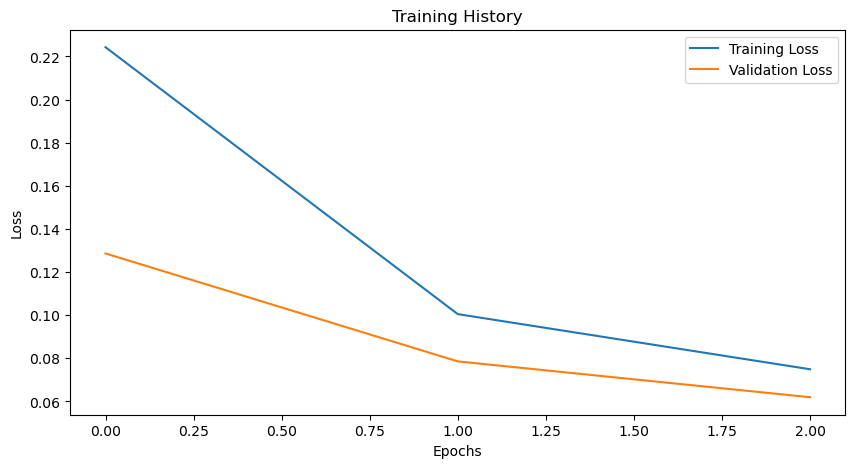

Training completed!


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from pathlib import Path
import os
import glob
from torchvision import transforms
import matplotlib.pyplot as plt

# Fixed Segmentation Dataset
class LandslideDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_size=256):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_size = (img_size, img_size)
        
        # Find matching pairs
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.tif")))
        self.mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.tif")))
        
        # Create pairs based on matching filenames
        self.pairs = []
        for img_path in self.image_files:
            img_name = Path(img_path).stem
            # Try to find corresponding mask
            mask_name = img_name.replace('image', 'mask')
            mask_path = os.path.join(masks_dir, f"{mask_name}.tif")
            
            if os.path.exists(mask_path):
                self.pairs.append((img_path, mask_path))
            else:
                # Try alternative naming convention
                mask_name = img_name
                mask_path = os.path.join(masks_dir, f"{mask_name}.tif")
                if os.path.exists(mask_path):
                    self.pairs.append((img_path, mask_path))
        
        print(f"Found {len(self.pairs)} image-mask pairs")
        
        # Basic transforms
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        
        try:
            # Read image
            with rasterio.open(img_path) as src:
                image = src.read()  # (C, H, W)
                image = np.transpose(image, (1, 2, 0))  # (H, W, C)
                
                # Handle different number of channels
                if image.shape[2] > 3:
                    image = image[:, :, :3]  # Take first 3 channels
                elif image.shape[2] == 1:
                    image = np.repeat(image, 3, axis=2)  # Convert to 3 channels
                
                # Normalize to [0, 1]
                if image.dtype != np.float32:
                    image = image.astype(np.float32)
                    if image.max() > 1.0:
                        image = image / 255.0
            
            # Read mask
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # Read first band
                
                # Ensure mask is binary (0 and 1)
                mask = mask.astype(np.float32)
                if mask.max() > 1.0:
                    mask = (mask > 0).astype(np.float32)
                else:
                    mask = mask.astype(np.float32)
            
            # Resize if needed
            if image.shape[:2] != self.img_size:
                from PIL import Image
                image_pil = Image.fromarray((image * 255).astype(np.uint8))
                mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
                
                image_pil = image_pil.resize(self.img_size, Image.BILINEAR)
                mask_pil = mask_pil.resize(self.img_size, Image.NEAREST)
                
                image = np.array(image_pil).astype(np.float32) / 255.0
                mask = np.array(mask_pil).astype(np.float32) / 255.0
            
            # Convert to tensors
            image_tensor = torch.from_numpy(image).permute(2, 0, 1)  # (C, H, W)
            mask_tensor = torch.from_numpy(mask).unsqueeze(0)  # (1, H, W)
            
            return {
                'pixel_values': image_tensor,
                'labels': mask_tensor.squeeze(0).long()  # Remove channel dim for loss
            }
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a dummy sample
            dummy_image = torch.randn(3, self.img_size[0], self.img_size[1])
            dummy_mask = torch.zeros(self.img_size[0], self.img_size[1]).long()
            return {
                'pixel_values': dummy_image,
                'labels': dummy_mask
            }

# U-Net Model (Fixed)
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        # Ensure input is 4D
        if x.dim() == 3:
            x = x.unsqueeze(0)
            
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# U-Net components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Training function
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images = batch['pixel_values'].to(device)
            masks = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['pixel_values'].to(device)
                masks = batch['labels'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss == min(val_losses):
            torch.save(model.state_dict(), 'best_model.pth')
            print('  Best model saved!')
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()
    
    return model

# Create datasets and dataloaders
print("Creating datasets...")
train_dataset = LandslideDataset(train_images_dir, train_masks_dir, img_size=256)
val_dataset = LandslideDataset(train_images_dir, train_masks_dir, img_size=256)  # Use same for validation for now

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Test one batch
sample_batch = next(iter(train_loader))
print(f"Image batch shape: {sample_batch['pixel_values'].shape}")
print(f"Mask batch shape: {sample_batch['labels'].shape}")
print(f"Image range: [{sample_batch['pixel_values'].min():.3f}, {sample_batch['pixel_values'].max():.3f}]")
print(f"Mask unique values: {torch.unique(sample_batch['labels'])}")

# Initialize model and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Training U-Net...")
model = UNet(n_channels=3, n_classes=2)

# Train
trained_model = train_model(model, train_loader, val_loader, device, epochs=3, lr=1e-4)

print("Training completed!")

Visualizing predictions...


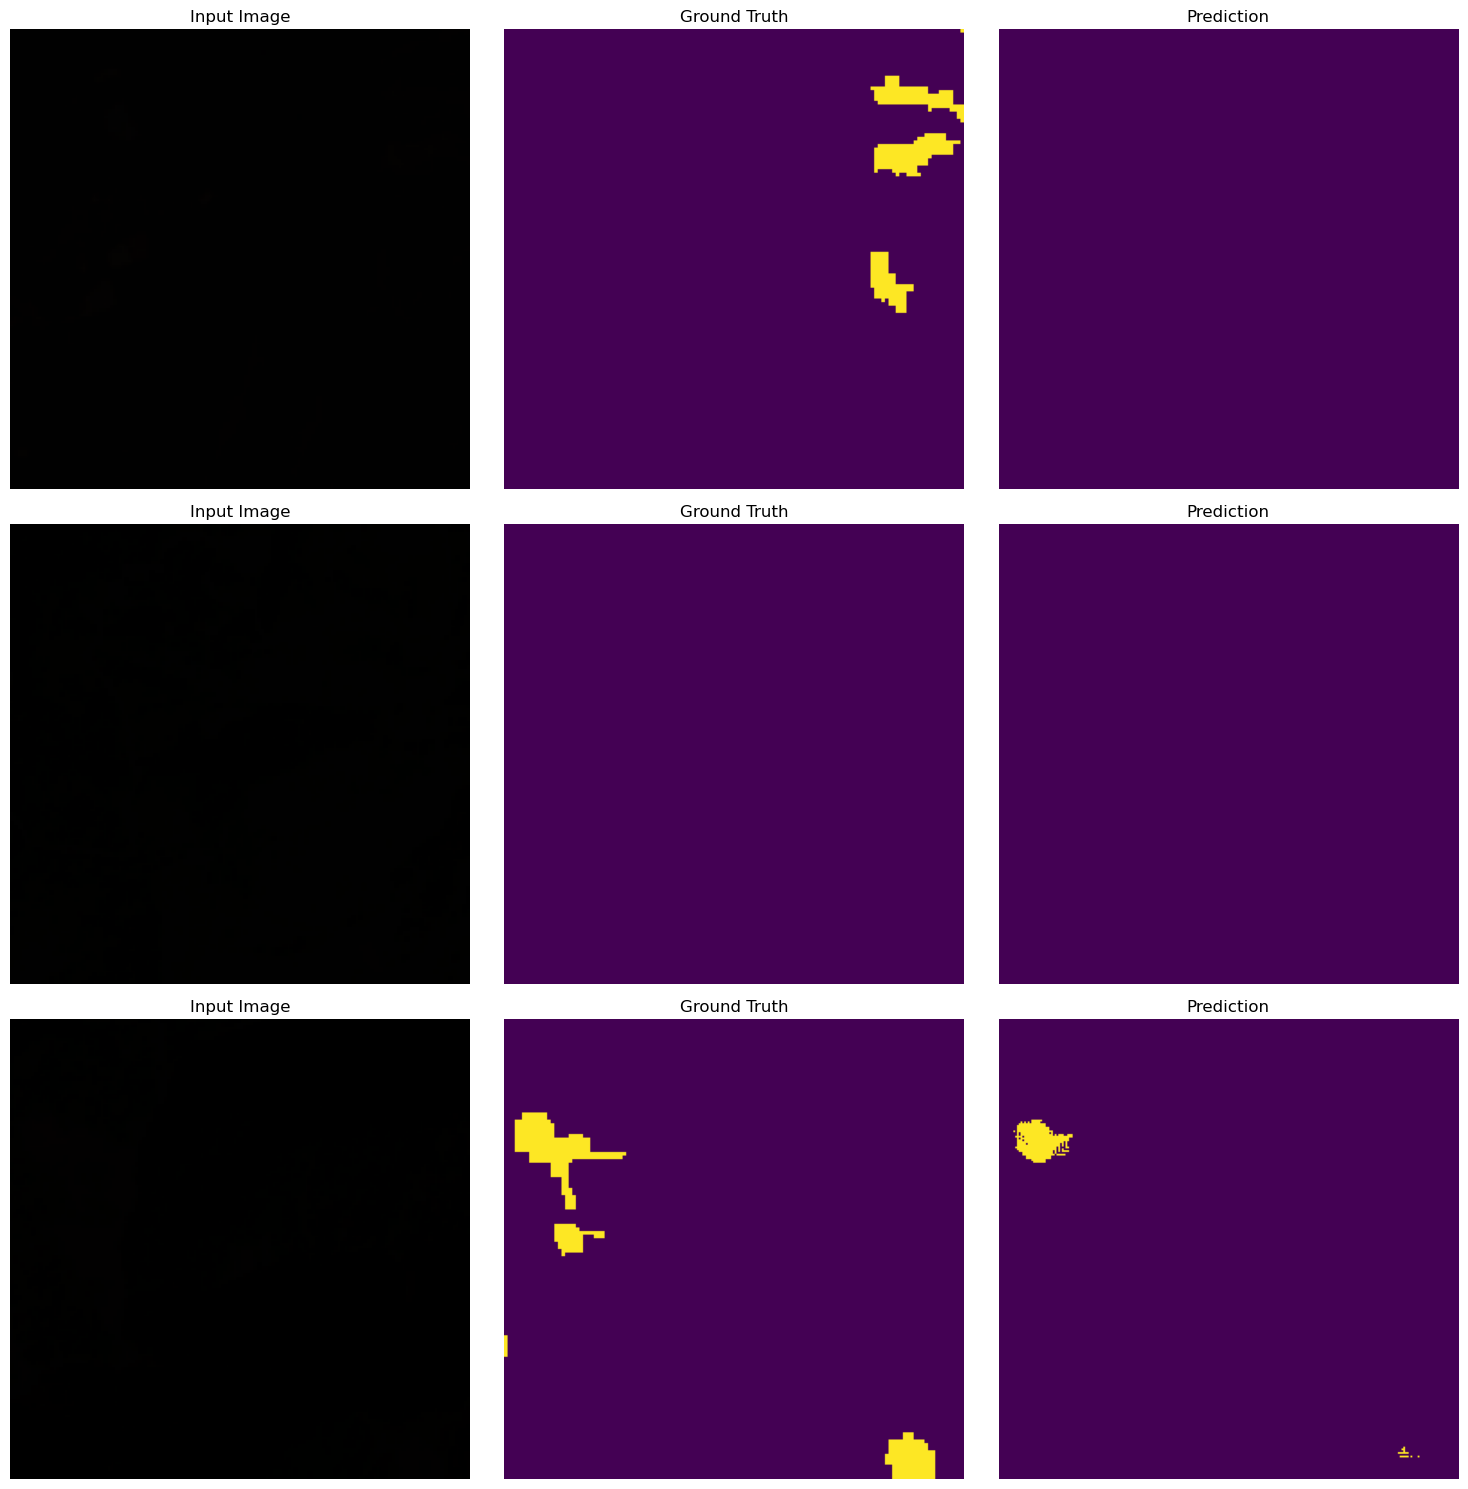

In [14]:
def visualize_predictions(train_model, dataset, device, num_samples=10):
    """Visualize model predictions"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        sample = dataset[i]
        image = sample['pixel_values'].unsqueeze(0).to(device)
        true_mask = sample['labels'].numpy()
        
        with torch.no_grad():
            prediction = model(image)
            pred_mask = torch.argmax(prediction, dim=1).squeeze().cpu().numpy()
        
        # Convert image for plotting
        img_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        # Plot
        if num_samples == 1:
            ax_img, ax_true, ax_pred = axes
        else:
            ax_img, ax_true, ax_pred = axes[i]
        
        ax_img.imshow(img_np)
        ax_img.set_title('Input Image')
        ax_img.axis('off')
        
        ax_true.imshow(true_mask, cmap='viridis')
        ax_true.set_title('Ground Truth')
        ax_true.axis('off')
        
        ax_pred.imshow(pred_mask, cmap='viridis')
        ax_pred.set_title('Prediction')
        ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
print("Visualizing predictions...")
visualize_predictions(trained_model, val_dataset, device, num_samples=3)